In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


In [2]:
# set plot default 
# set font
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.size'] = 13.0
mpl.rcParams['font.family'] = 'sans-serif'#'sans-serif', 'monospace'
# set axes
mpl.rcParams['axes.titlesize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'large'
# legend
mpl.rcParams['legend.fontsize'] = 'large'
# figure
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
#mpl.rcParams['figure.dpi'] = 90
mpl.rcParams['figure.titlesize'] = 'xx-large'
#mpl.rcParams['savefig.dpi'] = 90
mpl.rcParams['savefig.bbox'] = 'standard' # 'tight' is incompatible with pipe-based animation
mpl.rcParams['savefig.transparent'] = 'False' 


In [3]:
tfreeze = 273.16
tzero   = 273.15


In [ ]:
class SummaPlot:
    
    # some constant parameters
    _VAR_NAME_HEIGHT = 'iLayerHeight'
    _LAYER_DIM = {
        "midSnowAndTime" : ("midSnowStartIndex", 'nSnow') ,
        "midSoilAndTime" : ("midSoilStartIndex", 'nSoil') ,
        "midTotoAndTime" : ("midTotoStartIndex", 'nLayers') ,
        "ifcSnowAndTime" : ("ifcSnowStartIndex", 'nSnow') ,
        "ifcSoilAndTime" : ("ifcSoilStartIndex", 'nSoil') ,
        "ifcTotoAndTime" : ("ifcTotoStartIndex", 'nLayers') ,
        }
    _NVERT = 4
    _NCOOR = 2 
    
    def __init__(self,  ds, *args, **kwargs):   
        if type(ds) == xr.Dataset:
            self.ds = ds
        else:
            raise TypeError('must provide xarray.Dataset')

        
    def _add_block(x1, x2, y1, y2):
        """
        add the verts (four points) of a layer of a column
        """
        block_pts = np.empty([SummaPlot._NVERT, SummaPlot._NCOOR])  # allocate space is faster than np.array([...])
        block_pts[0, 0] = x1; block_pts[0, 1] = y1 # point 1
        block_pts[1, 0] = x2; block_pts[1, 1] = y1 # point 2
        block_pts[2, 0] = x2; block_pts[2, 1] = y2 # point 3
        block_pts[3, 0] = x1; block_pts[3, 1] = y2 # point 4
        return block_pts
 
   
    def _add_column(time1, time2, heights):
        """
        add the vertices of a column
        """
        n = heights.shape[0] - 1
        verts = np.array([ SummaPlot._add_block(time1, time2, heights[i], heights[i + 1]) for i in range(n) ])
        return verts    
    
    
    def date2num4plt(times):
        '''
        convert the netcdftime stmp to the datetime series 
        that recognized by matplotlib        
        '''
        return mpl.dates.date2num([ pd.Timestamp(t).to_datetime() for t in times.values ])

 
    def get_layer_sindex(ds, var_name):
        '''
        get the starting layer index
        '''
        dims = ds[var_name].dims
        for k in SummaPlot._LAYER_DIM.keys():
            if k in dims:
                return ds[SummaPlot._LAYER_DIM[k][0]] - 1
    
    def _split_time_layer(ds, var_name):
        '''
        split the ragged time layer dimemsion
        '''
        # find the ragged_dim_name
        ragged_dim_name = ''
        dims = list(ds[var_name].dims)
        for k in SummaPlot._LAYER_DIM.keys():
            if k in dims:
                ragged_dim_name = k
        if ragged_dim_name == '':
            raise KeyError(var_name + ' is not a ragged variable')
        addlayer = 1 if ragged_dim_name[0] == 'i' else 0
        max_time = ds.dims['time']
        max_hru = ds.dims['hru']
        idx_ragged = ds[SummaPlot._LAYER_DIM[ragged_dim_name][0]].values
        nlayer = ds[SummaPlot._LAYER_DIM[ragged_dim_name][1]].values
        max_layer = nlayer.max() + addlayer
        #idx_ragged
        # split mSnow
        
        vals = np.empty([max_time, max_hru, max_layer])
        vals.fill(np.nan)
        val_ori = ds[var_name].values
        #for v in ds.data_vars:
            
        for itime in range(ds.dims['time']):
            for ihru in range(ds.dims['hru']):
                vals[itime, ihru, np.arange(nlayer[itime, ihru] + addlayer)] = val_ori[idx_ragged[itime, ihru] - 1 + np.arange(nlayer[itime, ihru] + addlayer), ihru]
                
        return xr.Dataset({var_name: (['time', 'hru', ragged_dim_name[0] + 'layer'], vals), 
                          'nLayers': (['time', 'hru'], nlayer)})
        
    
    def _squeeze(ds, var_name, desired_dim, other_index):
        """
        Reduce the variable in the input DataSet to the desired dimension
        
        Arguments
        ----------
        ds (xarray.Dataset): required
            An xarray Dataset
        var_name (str): required
            Name of the variable whose dimension to be reduced
        desired_dim (str or list-liked): required
            Name of the desired dimension
        other_index (list-like or integer): required
            Indices to be used for other dimension, 
            followed the dimension order of the dataset
            
        Returns
        -------
        ds_slim (number): 
            The average of a and b, computed using 0.5*(a + b)
        Exceptions
        -------
        
        Example
        -------
        >>> ds = xarray.Dataset({'v1': (['x', 'y', 'z'], numpy.random.randn(2, 2, 3)),
        ...                      'v2': (['x', 'y'], numpy.random.randn(2, 2))})
        >>> ds
        <xarray.Dataset>
        Dimensions:  (x: 2, y: 2, z: 3)
        Coordinates:
          * x        (x) int64 0 1
          * y        (y) int64 0 1
          * z        (z) int64 0 1 2
        Data variables:
            v2       (x, y) float64 -0.8387 1.236 -1.7 1.118
            v1       (x, y, z) float64 -1.482 1.793 -0.311 -0.7124 -1.172 -1.274 ...
        >>> _squeeze(ds, 'v1', 'z', (0, 0))
        <xarray.Dataset>
        Dimensions:  (z: 3)
        Coordinates:
            x        int64 0
            y        int64 0
          * z        (z) int64 0 1 2
        Data variables:
            v2       float64 -0.8387
            v1       (z) float64 -1.482 1.793 -0.311
        
        """
        
        # check if the desired is a layer variable
        
 
        dims = list(ds[var_name].dims)
        # get the nested dim (layer + time)
        for k in SummaPlot._LAYER_DIM.keys():
            if k in dims:
                raise TypeError('Could not squeeze the ragged time-layer dimension')
        
        #
        if type(desired_dim) == str:
            dims.remove(desired_dim)
        else:
            for d in desired_dim:
                dims.remove(d)
        # squeeze
        if type(other_index) == int:
            other_index = [other_index]
        others = {d:i for d, i in zip(dims, other_index)}  
        return ds[others]
            
        


    # TODO: plot the map showing spatial distribution of a variable   
    def plot2d_map(self):
        
        # it must have the hru dimemsion
        pass
    
    
    # TODO: plot the map showing spatial distribution of a variable (rasterize before plotting) 
    def rasterize_hru_map(self, idx_grid):
        
        # it must have the hru dimemsion
        pass
    
    
    # TODO: plot the map showing spatial distribution of a variable (rasterize before plotting) 
    def plot2d_fast_map(self, idx_grid, gdf):
        
        # it must have the hru dimemsion
        pass
    
    # TODO: sdsd
    def plot_curve(self, var_name, new_name=None,freq=1, val_mult=1.0, val_offset=0.0, val_range=None, 
                   x_axis='time', idx_other=0, xlim=None, ylim=None, logx=False, logy=False, ax=None,
                   figsize=(12, 6), legend=True, legend_title='', table=False,
                   title='', secondary_y=False, ylab='', rylab='', **kwargs): 
        """
        Reduce the variable in the input DataSet to the desired dimension
        
        Arguments
        ----------
        ds (xarray.Dataset): required
            An xarray Dataset
        var_name (str): required
            Name of the variable to be plotted
        new_name (str): optional, default=None
            Name used to label the variable in the Legend
        other_index (list-like or integer): required
            Indices to be used for other dimension, 
            followed the dimension order of the dataset
            
        Returns
        -------
        ds_slim (number): 
            The average of a and b, computed using 0.5*(a + b)
        Exceptions
        -------
        
        Example
        -------
        >>> ds = xarray.Dataset({'v1': (['x', 'y', 'z'], numpy.random.randn(2, 2, 3)),
        ...                      'v2': (['x', 'y'], numpy.random.randn(2, 2))})
        >>> ds
        <xarray.Dataset>
        Dimensions:  (x: 2, y: 2, z: 3)
        Coordinates:
          * x        (x) int64 0 1
          * y        (y) int64 0 1
          * z        (z) int64 0 1 2
        Data variables:
            v2       (x, y) float64 -0.8387 1.236 -1.7 1.118
            v1       (x, y, z) float64 -1.482 1.793 -0.311 -0.7124 -1.172 -1.274 ...
        >>> _squeeze(ds, 'v1', 'z', (0, 0))
        <xarray.Dataset>
        Dimensions:  (z: 3)
        Coordinates:
            x        int64 0
            y        int64 0
          * z        (z) int64 0 1 2
        Data variables:
            v2       float64 -0.8387
            v1       (z) float64 -1.482 1.793 -0.311
        
        """
        
        # get the dimension names
        ds = SummaPlot._squeeze(self.ds, var_name, x_axis, idx_other)  
              
        df = ds[var_name].to_dataframe()[var_name]
        
        # plot
        if ax == None:
            fig, ax = plt.subplots(figsize=figsize)
            
        # apply transformation    
        df = (df * val_mult - val_offset)
        if new_name != None:
            df.columns = new_name
        if val_range != None:
            df = df.mask(df < val_range[0]).mask(df > val_range[1])
            
                    
        df.plot(ax=ax, legend=legend, xlim=xlim, ylim=ylim, title=title, logx=logx, logy=logy, table=table, secondary_y=secondary_y, mark_right=False)
        if ylab != '':
            ax.set_ylabel(ylab)
        if rylab != '':
            ax.right_ax.set_ylabel(rylab)
        #ax.legend(title=legend_title)
        return ax

        
    
    def plot_column(self, var_name, freq=1, val_offset=0.0, val_range=None, 
                   x_axis='time', interval=1, idx_other=0, xlim=None, ylim=None, ax=None,
                   figsize=(12, 6), legend=True, legend_title=None, cmap='jet', norm=None,
                   annotate=False, fontsize=8, decimals=3, extend='neither', title='', **kwargs):
        
        
        ds = self.ds
            
        if x_axis == 'time':
            # create the datetime series that recognized by matplotlib             
            x = SummaPlot.date2num4plt(ds.time) 
        else:
            x = ds[x_axis]
            
        # adding the end x based on delta(x)
        dx = x[-1] - x[-2]
        x = np.append(x, x[-1] + dx)
            
            
        x_len = x.shape[0] - 1
        # squeeze
        # layer variable values
        ds_val = SummaPlot._split_time_layer(ds, var_name) 
        ds_val = SummaPlot._squeeze(ds_val, var_name, [x_axis, var_name[0] + 'layer'], idx_other) 
        # layer height
        ds_hgt = SummaPlot._split_time_layer(ds, SummaPlot._VAR_NAME_HEIGHT)  
        ds_hgt = SummaPlot._squeeze(ds_hgt, SummaPlot._VAR_NAME_HEIGHT, [x_axis, 'ilayer'], idx_other)

        vals  = np.empty(0)
        verts = np.empty([0, SummaPlot._NVERT, SummaPlot._NCOOR])
        
        for i in range(0, x_len, freq):   
            idx_x   = i + freq - 1 # the ending time index of the current plot step
            nLayers    = ds_val['nLayers'][idx_x]
            val_col    = ds_val[var_name].values[idx_x, np.arange(nLayers)]
            heights    = -ds_hgt[SummaPlot._VAR_NAME_HEIGHT].values[idx_x, np.arange(nLayers + 1)]           # layer heights
            vals       = np.append(vals, val_col)     # values
            verts      = np.append(verts, SummaPlot._add_column(x[i], x[idx_x + 1], heights), axis=0)     # vertices
            
        # clean up and apply mask
        if val_offset != 0.0: 
            vals = vals - val_offset 
            
        if val_range != None:
            mask = (vals >= val_range[0]) & (vals <= val_range[1])
            vals  = vals[mask]
            verts = verts[mask,:,:]

        # plot
        if ax == None:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            fig = ax.get_figure()
            
        # prepare colormap
        if val_range != None and norm == None:
            norm = mpl.colors.Normalize(vmin=min(val_range), vmax=max(val_range))
        coll = PolyCollection(verts, array = vals, cmap=cmap, edgecolors='none', norm=norm)
        ax.add_collection(coll)
        
        # set axis
        ax.autoscale_view()
        ax.yaxis.set_label_text('depth (m)')
        ax.xaxis.set_label_text(x_axis)
        if x_axis=='time':
            ax.xaxis_date()
            x_range = x.max() - x.min()
            if x_range < 1.5: # datetime.timedelta(days = 1.5):
                ax.xaxis.set_major_locator(mpl.dates.HourLocator(interval=interval))
                ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))            
            fig.autofmt_xdate()    
            
        if ylim != None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim()
            
        if xlim == None:
            xlim = min(x), max(x)        
        ax.set_xlim(xlim)
        
        # add annotation
        if annotate == True:
            tx  = np.round(vals, decimals=decimals).astype(str)
            txx = verts[:,:,0].mean(axis=1)
            tyy = verts[:,:,1].mean(axis=1)
            for t_x, t_y, t_s in zip(txx, tyy, tx):
                if t_x > xlim[0] and t_x < xlim[1] and t_y > ylim[0] and t_y < ylim[1]:
                    ax.text(t_x, t_y, t_s, fontsize=fontsize, ha='center', va='center')
                            
        # set legend        
        if legend == True:
            ax.legend()
            if legend_title == None:
                legend_title = var_name + ' (' + ds[var_name].attrs['units'] + ')'
            fig.colorbar(coll, ax=ax, label=legend_title, extend=extend)
        
        ax.set_title(title)
        return ax
        

## Open a SUMMA output file and create an SummaPlot object

In [5]:
ds_all = xr.open_dataset(r"D:\Cloud\Dropbox\postdoc\summa\summaData\problematicHRU\snow_too_low\columbia_snow_too_low_spinup_1.nc")
sp = SummaPlot(ds_all)

## plot curve

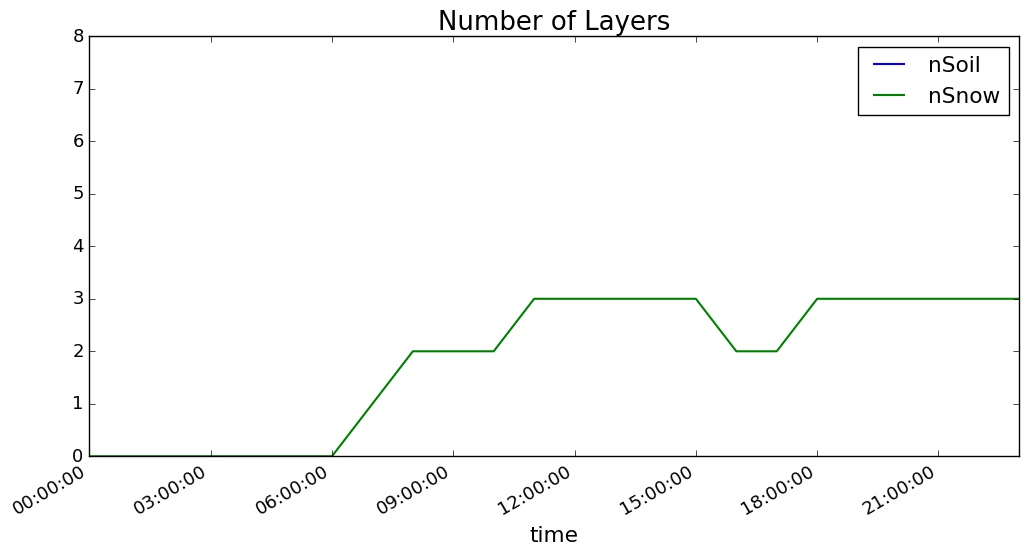

In [7]:
sp.plot_curve(['nSoil','nSnow'], title='Number of Layers')

### dual Y axises

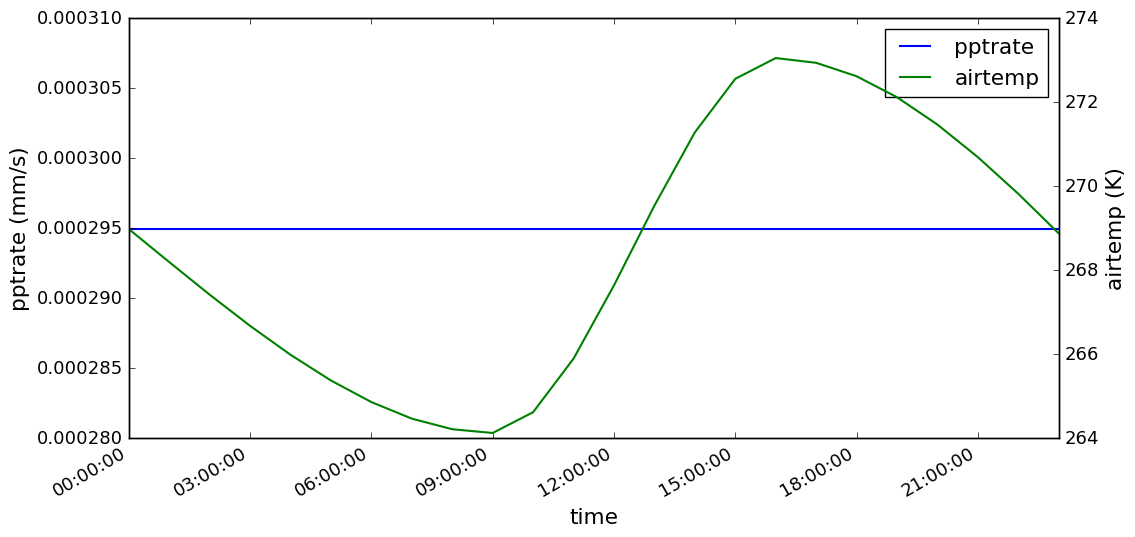

In [8]:
sp.plot_curve(['pptrate','airtemp'], secondary_y=['airtemp'], ylab='pptrate (mm/s)', rylab='airtemp (K)')

### plot data across several output files

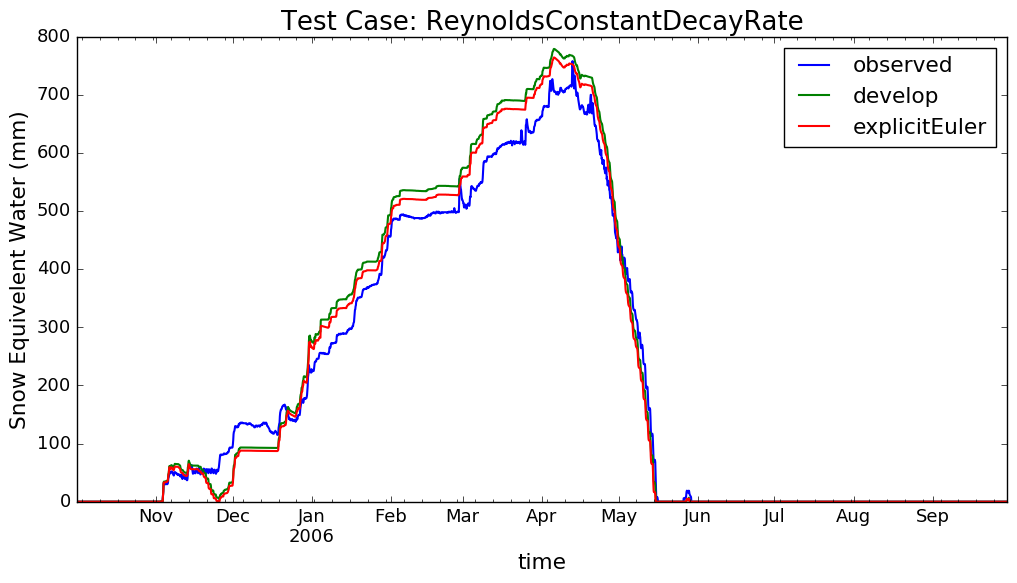

In [11]:
ds_obs = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaTestCases\testCases_data_org\validationData\ReynoldsCreek_valData.nc')
ds_dep = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaData\summaTestCases\output_develop\wrrPaperTestCases\figure06\albedoTest_2005-2006_reynoldsConstantDecayRate_1.nc')
ds_exp = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaData\summaTestCases\output_explicitEuler\wrrPaperTestCases\figure06\albedoTest_2005-2006_reynoldsConstantDecayRate_1.nc')

for k in ds_dep.data_vars.keys(): ds_dep.rename({k: 'dep_' + k}, inplace=True)
for k in ds_exp.data_vars.keys(): ds_exp.rename({k: 'exp_' + k}, inplace=True)

ds_all = xr.merge([ds_obs['SWE'], ds_dep['dep_scalarSWE'], ds_exp['exp_scalarSWE']], join='inner')
sp = SummaPlot(ds_all)
ax = sp.plot_curve(['SWE','dep_scalarSWE','exp_scalarSWE'], 
                   title='Test Case: ReynoldsConstantDecayRate', 
                   ylab='Snow Equivelent Water (mm)', 
                   new_name=['observed','develop', 'explicitEuler'])

### plot profile alomg time

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:264: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:265: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


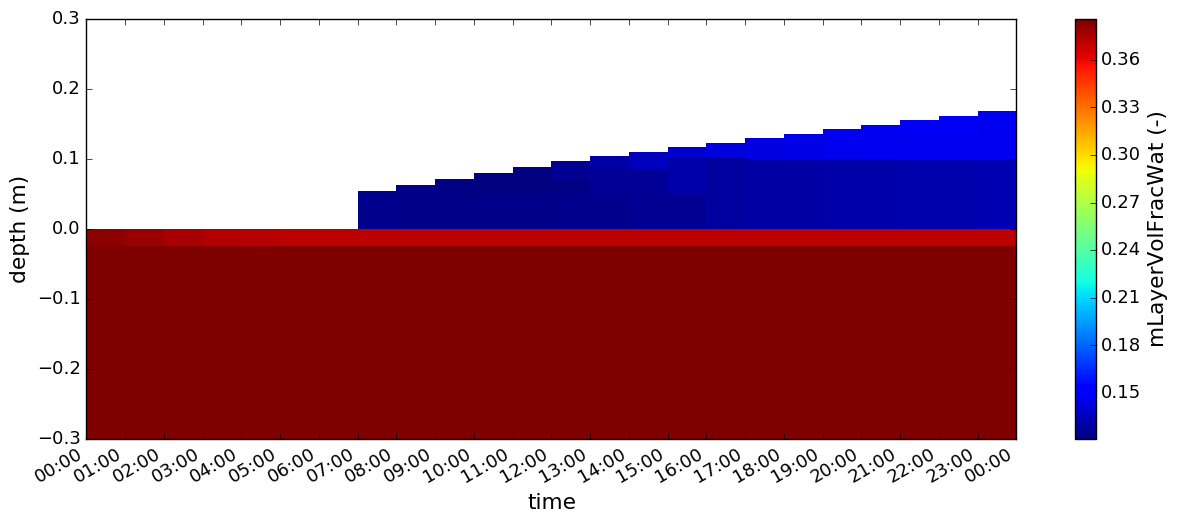

In [13]:
ds_all = xr.open_dataset(r"D:\Cloud\Dropbox\postdoc\summa\summaData\problematicHRU\snow_too_low\columbia_snow_too_low_spinup_1.nc")
sp = SummaPlot(ds_all)
sp.plot_column('mLayerVolFracWat', ylim=(-0.3, 0.3), figsize=(15, 6))

### add annotation to profile plot

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:264: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:265: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


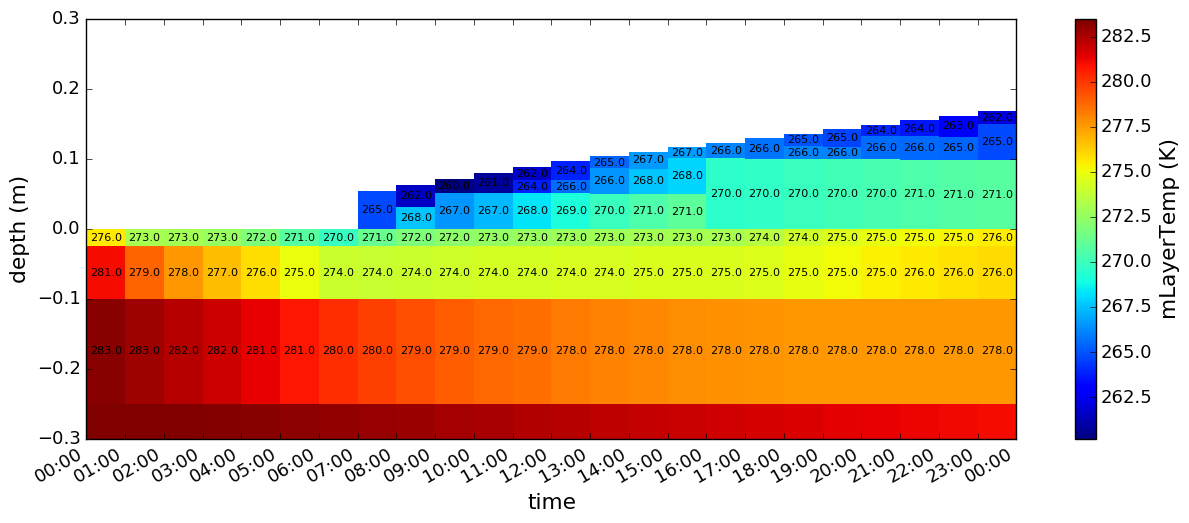

In [16]:
sp.plot_column('mLayerTemp', ylim=(-0.3, 0.3), figsize=(15, 6),  annotate=True, decimals=0)

### Multiple profile plot

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:264: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:265: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


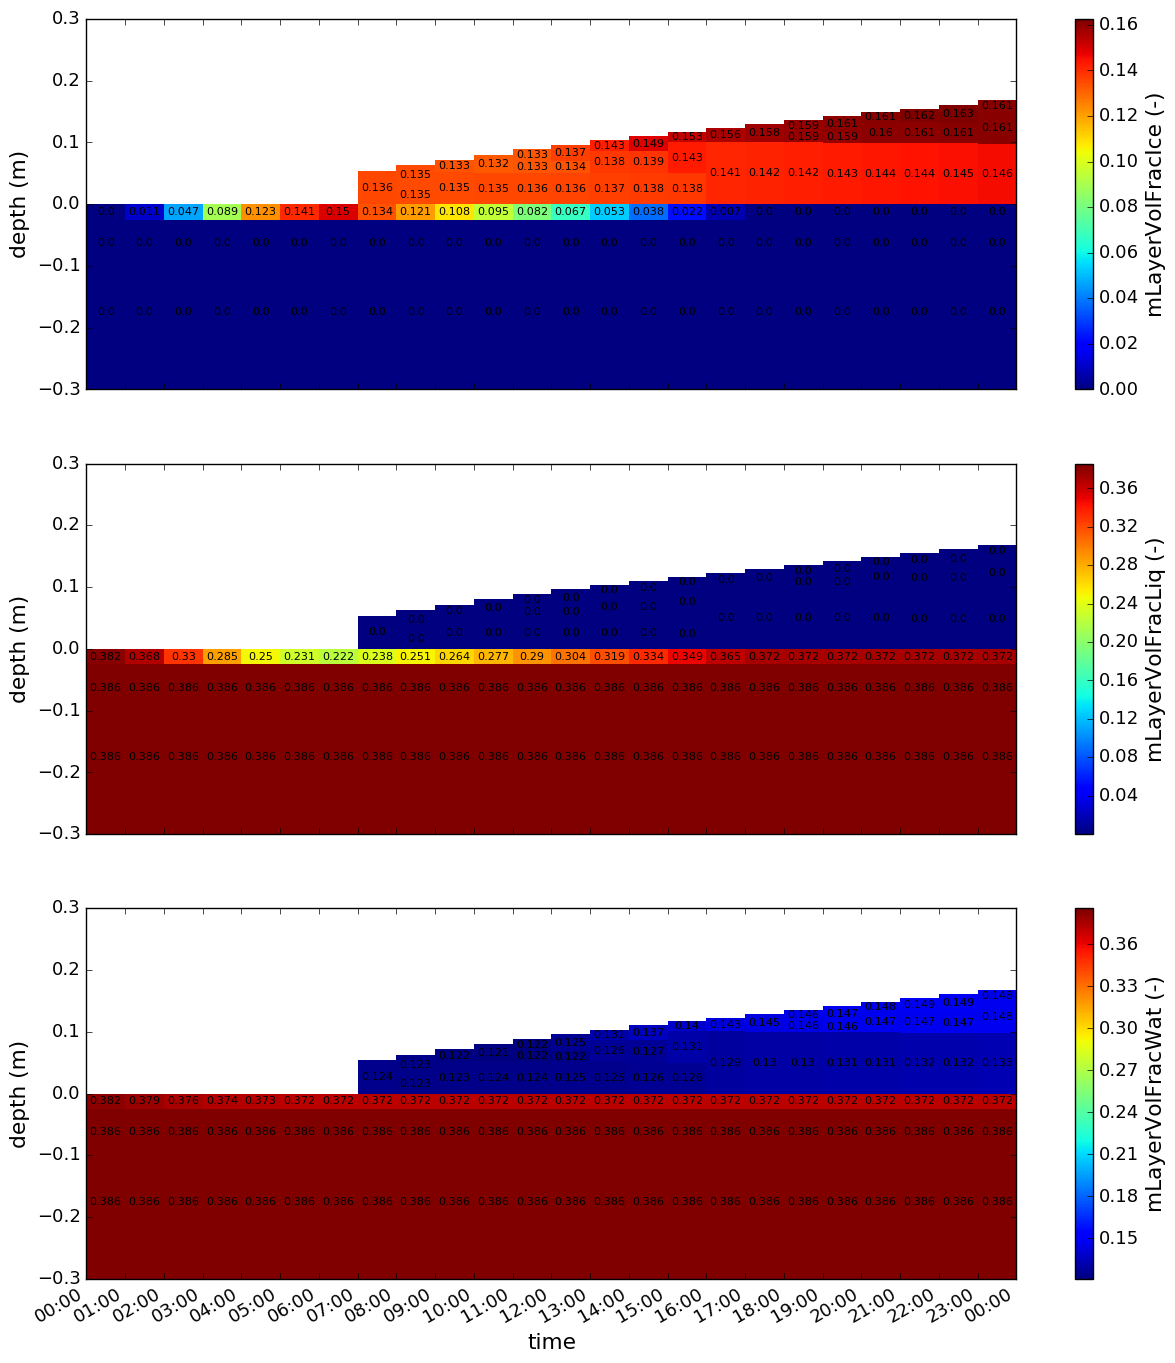

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(15, 18))
sp.plot_column('mLayerVolFracIce', ylim = (-0.3, 0.3), ax=ax[0], legend=True, annotate=True)
sp.plot_column('mLayerVolFracLiq', ylim = (-0.3, 0.3), ax=ax[1], legend=True, annotate=True)
sp.plot_column('mLayerVolFracWat', ylim = (-0.3, 0.3), ax=ax[2], legend=True, annotate=True)

### plot profiles along HRUs

In [152]:
ds_all = xr.open_dataset(r"D:\Cloud\Dropbox\postdoc\summa\summaData\problematicHRU\snow_too_low\columbia_snow_too_low_spinup_1.nc")
sp = SummaPlot(ds_all)

Wall time: 0 ns


array([[ 1, 11],
       [ 2, 11],
       [ 2, 12],
       [ 1, 12]])

In [ ]:
#plt.colorbar(coll, label='Temeprature (C)') #, orientation = 'horizontal', anchor = (0.8, 0.5))
# add 
#cbar_ax_abs = fig.add_axes([0.03, 0.2, 0.015, 0.6])
#cbar_ax_abs.tick_params(labelsize=14)
#cbar_abs = matplotlib.colorbar.ColorbarBase(cbar_ax_abs, cmap=swe_cmap,norm=norm).set_label(label='Snow Water Equivalent (mm)', size=16, labelpad=-85)
      
#%% plot curve
ds.pptrate.plot(ax = axppt, color='green')#, marker='d')
axppt.set_title("") #axppt.set_title(ds.pptrate.long_name + " (" + ds.pptrate.units + ")")
ds.airtemp.plot(ax = axtemp, color='purple')#, marker='o')
axtemp.set_title("") #axtemp.set_title(ds.airtemp.long_name + " (C)")
    
#fig.savefig('summa_profiles.png',dpi=300,bbox_inches='tight')

#%%


In [ ]:
#%% try grid plot

fig, axes = plt.subplots(ncols=2)
fig = plt.figure(figsize=(10, 10)); gs = gridspec.GridSpec(nrows = 3, ncols = 1, height_ratios= [1, 1, 3]) 
axppt = plt.subplot(gs[0]); ds.pptrate.plot(ax = axppt)
axtemp = plt.subplot(gs[1]); ds.airtemp.plot(ax = axtemp)
axs = plt.subplot(gs[2]); ds.pptrate.plot(ax = axs)



grid = np.random.rand(4, 3)
fig, axes = plt.subplots(figsize=(12, 6))
axes.imshow(grid, aspect = 'auto')
axes.matshow?






plt.savefig('grid_figure.pdf')

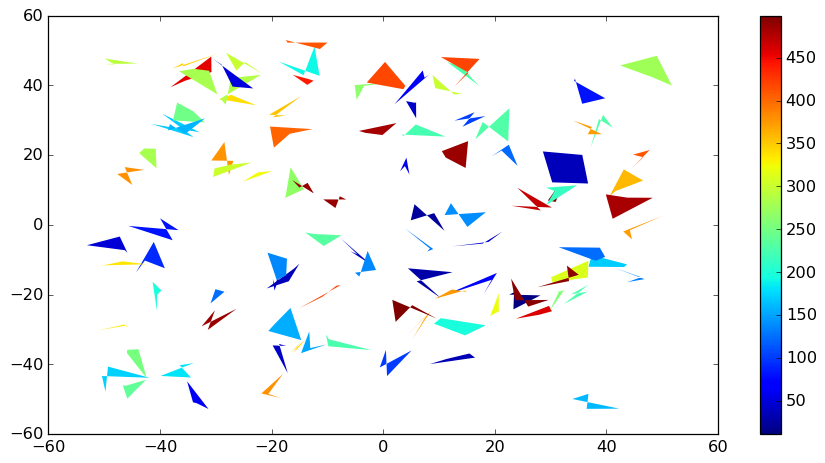

Wall time: 398 ms


In [18]:
#%%
def plot_patch_example():
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection
    import matplotlib as mpl

    # Generate data. In this case, we'll make a bunch of center-points and generate
    # verticies by subtracting random offsets from those center-points
    numpoly, numverts = 100, 4
    centers = 100 * (np.random.random((numpoly,2)) - 0.5)
    offsets = 10 * (np.random.random((numverts,numpoly,2)) - 0.5)
    verts = centers + offsets
    verts = np.swapaxes(verts, 0, 1)

    # In your case, "verts" might be something like:
    # verts = zip(zip(lon1, lat1), zip(lon2, lat2), ...)
    # If "data" in your case is a numpy array, there are cleaner ways to reorder
    # things to suit.

    # Color scalar...
    # If you have rgb values in your "colorval" array, you could just pass them
    # in as "facecolors=colorval" when you create the PolyCollection
    z = np.random.random(numpoly) * 500

    fig, ax = plt.subplots()

    # Make the collection and add it to the plot.
    coll = PolyCollection(verts, array=z, cmap=mpl.cm.jet, edgecolors='none')
    #coll = PolyCollection(verts)
    ax.add_collection(coll)
    ax.autoscale_view()

    # Add a colorbar for the PolyCollection
    fig.colorbar(coll, ax=ax)
    plt.show()

%time plot_patch_example()

In [34]:
class SummaPlot():
    a = 1
    b = 2
    def __init__(self, ds):
        print(self.a)
        self.ds = ds
        
    #@staticmethod
    def descrip(okk):
        print(okk)
        
    def printme(self):
        SummaPlot.descrip('ddd')
        
a = SummaPlot(ds_all)
a.printme()

1
ddd
